# Schedule TPC-DS 1 Feature Selection

This notebook is dedicated to dataset profiling. In this notebook, feature selection techniques will be implemented so as to categorize which features belay the most information to address the problem at hand - Workload Prediction. Due to the vast feature space which have been gathered during a workload's execution, manual techniques at determining which are most detrimental is not sufficient. 

Therefore the following work puts emphasis on automated techniques so as to determine out of the vast feature space which are most important to base future models upon. 

In [82]:
#
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import r2_score

In [83]:
tpcds='TPCDS1' # Schema upon which to operate test
debug_mode=True # Determines whether to plot graphs or not, useful for development purposes 
low_quartile_limit = 0 # Lower Quartile threshold to detect outliers
upper_quartile_limit = 1 # Upper Quartile threshold to detect outliers
test_split=.3 # Denotes which Data Split to operate under when it comes to training / validation
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (26,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset Description

The correlation of resources consumed (y) per snapshot (X) define our feature space. Since the objective here is to attempt to predict what resources will be incurred ahead of time, the problem can be defined as a number of questions:

* Q: What resources can I predict to be in usage at point N in time?
* Q: What resources should I be predicting that accurately portray a schedule's workload?
* Q: What knowledge/data do I have ahead of time which I can use to base my predictions off?

Due to the vast feature space in the available metrics monitored and captured during a workload's execution, it is important to rank which attribute is most beneficial than others. Additionally, it is important to analyze such features individually, and considerate of other features in two types of analysis:

* Univariate Analysis
* Multivariate Analysis

Furthermore, multiple types of feature ranking / analysis techniques ara available, amongst which will be considered:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Data Preprocessing

We apply a number of preprocessing techniques to the presented dataframes, particularly to normalize and/or scale feature vectors into a more suitable representation for downstream estimators:

Relative Links:
* http://scikit-learn.org/stable/modules/preprocessing.html
* https://machinelearningmastery.com/improve-model-accuracy-with-data-pre-processing/
* https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

### Table Pivots

To better handle the following table, a number of table pivots are made on tables:
* rep_hist_sysmetric_summary
* rep_hist_sysstat

In [84]:
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
print(rep_hist_sysmetric_summary_df.columns)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSMETRIC Shape: " + str(rep_hist_sysmetric_summary_df.shape))
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
print(rep_hist_sysstat_df.columns)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSSTAT_DF Shape: " + str(rep_hist_sysstat_df.shape))
#
# Refreshing columns with pivoted columns
def convert_list_to_upper(col_list):
    """
    Takes a string and converts elements to upper
    """
    upper_col_list = []
    for col in col_list:
        upper_col_list.append(col.upper())
    return upper_col_list
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
rep_hist_snapshot_headers = rep_hist_snapshot_df.columns
rep_hist_sysmetric_summary_headers = list(rep_hist_sysmetric_summary_df.columns)
rep_hist_sysstat_headers = list(rep_hist_sysstat_df.columns)
rep_vsql_plan_headers = rep_vsql_plan_df.columns
#
# DF Shape
print('\n\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))
print('Table [REP_VSQL_PLAN] - ' + str(rep_vsql_plan_df.shape))

Index(['SNAP_ID', 'Active Parallel Sessions', 'Active Serial Sessions',
       'Average Active Sessions',
       'Average Synchronous Single-Block Read Latency',
       'Background CPU Usage Per Sec', 'Background Checkpoints Per Sec',
       'Background Time Per Sec', 'Branch Node Splits Per Sec',
       'Branch Node Splits Per Txn',
       ...
       'User Commits Percentage', 'User Limit %',
       'User Rollback Undo Records Applied Per Txn',
       'User Rollback UndoRec Applied Per Sec', 'User Rollbacks Per Sec',
       'User Rollbacks Percentage', 'User Transaction Per Sec',
       'VM in bytes Per Sec', 'VM out bytes Per Sec',
       'Workload Capture and Replay status'],
      dtype='object', name='METRIC_NAME', length=162)
REP_HIST_SYSMETRIC Shape: (172, 162)
Index(['SNAP_ID', 'ADG global flush', 'ADG parselock X get attempts',
       'ADG parselock X get successes', 'BA au bytes allocated',
       'BA bytes for file maps', 'BA bytes read from disk',
       'BA bytes read from

### Checking for NaN Values

Checking dataframes for potential missing values/data:

In [85]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print("Table REP_HIST_SNAPSHOT: " + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

Table REP_HIST_SNAPSHOT: ['OPTIMIZER_COST', 'MODULE', 'ACTION', 'SQL_PROFILE', 'BIND_DATA', 'FLAG']


Table REP_HIST_SYSMETRIC_SUMMARY: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'DDL STATEMENTS PARALLELIZED PER SEC', 'DML STATEMENTS PARALLELIZED PER SEC', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'QUERIES PARALLELIZED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED', 'TOTAL PGA USED BY SQL WORKAREAS', 'VM IN BYTES PER SEC', 'VM OUT BYTES PER SEC', 'WORKLOAD CAPTURE AND REPLAY STATUS']


Table REP_HIST_SYSSTAT: ['FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM SPACE SMU CREATIONS COMMITTED', 'PARALLEL OPERATIONS DOWNGRADED TO SERIAL']


Table 

### Checking for Negative Values

A function which retrieves a count per column for nay negative values it might contain

In [86]:
def count_neg_df(df, headers):
    """
    Return columns with respective negative value count
    """
    neg_list = []
    for head in headers:
        count = 0
        try:
            count = sum(n < 0 for n in df[head].values.flatten())
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
        if count > 0:
            neg_list.append([head,count])
    return neg_list
#
def fill_neg(df, headers):
    """
    Sets any data anomilies resulting in negative values to 0
    
    :param headers: list as follows eg: ['column_name', 'negative_count']
    """
    for head in headers:
        try:
            df[df[head[0]] < 0] = 0
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
    return df
#
# Check For Negative Values within dataframes
print('---------------WITH NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
# Replace Negative Values with a minimal threshold of 0
rep_hist_snapshot_df = fill_neg(df=rep_hist_snapshot_df,headers=count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers))
rep_hist_sysmetric_summary_df = fill_neg(df=rep_hist_sysmetric_summary_df,headers=count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers))
rep_hist_sysstat_df = fill_neg(df=rep_hist_sysstat_df,headers=count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers))
rep_vsql_plan_df = fill_neg(df=rep_vsql_plan_df,headers=count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers))
#
# Check For Negative Values within dataframes
print('\n\n---------------WITHOUT NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")

---------------WITH NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: [['IO_OFFLOAD_RETURN_BYTES_TOTAL', 11], ['IO_OFFLOAD_RETURN_BYTES_DELTA', 6]]


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




---------------WITHOUT NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: []


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




## Visualizing Feature Distribution & Skewness

In order to decide between a normalization strategy, it is important to understand the underlying data spread. Understanding of dataset mean, variance, skewness on a per column/feature basis helps determine whether a standardization or normalization strategy should be utilized on the datasets.

### Plotting Data Distribution

To better decide which normalization technique ought to be utilized for the technique at hand, a number of feature columns will be plotted as histograms to better convey the distribution spread.

In [87]:
def plot_hist(df=None, tpc_type=None, table=None, feature_column=None, bin_size=10):
    """
    Plots histogram distribution
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(float)
        df[feature_column] = df[feature_column].astype(float)
        #
        max_val = df[feature_column].max()
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df[feature_column].hist(bins=10,figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('Bin Ranges Of ' + str(int(max_val/bin_size)))
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_scatter(df=None, tpc_type=None, table=None, feature_column=None):
    """
    Plots scatter plots vs SNAP_ID
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(int)
        df[feature_column] = df[feature_column].astype(int)
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df.plot.scatter(x='SNAP_ID',
                        y=feature_column,
                        figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('SNAP ID')
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_boxplot(df=None, tpc_type=None, table=None, feature_columns=None):
    """
    Plots quartile plots to estimate mean and sigma (std dev)
    """
    #
    try:
        for feature_column in feature_columns:
            df[feature_column] = df[feature_column].astype(int)
        df.boxplot(column=feature_columns, figsize=(12,8), grid=True)
        plt.title(tpc_type + ' ' + str(feature_columns))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
if debug_mode is False:
    #
    # Plotting Histograms of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysstat_df, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots of data distribution
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_headers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Outlier Handling

https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

As can be appreciated from the previous plots, data is heavily skewed on particular (smallest) bins. This skew in the plotted histograms is a result of data point outliers - these need to be evaluated and removed if neccessary.

Following the 3 Standard Deviation Rule, we can categorize our dataset into subsets consisting of the following ranges:
* 0     - 68.27%
* 68.28 - 95.45%
* 95.46 - 99.73%
* 99.74 - 100%

It should be mentioned, that given the time series nature of the dataset, it is not a safe assumption to ignore outliers. By training respective models on outlier insensitive dataset, we would invite a potential problem, which risks blinding any models we train to future predicted spikes of activity.

In [88]:
def get_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            series_row = (df[df[header] > q].index)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            q = df[header].quantile(low_quartile_limit)
            series_row = (df[df[header] < q].index)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
        except Exception as e:
            print(str(e))
    #
    unique_ids = []
    unique_outlier_rows = []
    #
    for col, rowid in outlier_rows:
        if rowid not in unique_ids:
            unique_outlier_rows.append([col,rowid])
            unique_ids.append(rowid)
    return unique_outlier_rows
#
def remove_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Remove rows which are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    length_before = len(df)
    outliers_index = []
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] > q].index)))
            q = df[header].quantile(low_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] < q].index)))
        except Exception as e:
            print(str(e))
    #flat_outliers_index = [item for sublist in l for item in outliers_index]
    flat_outliers_index = [item for sublist in outliers_index for item in sublist]
    outliers_index = list(set(flat_outliers_index))
    df = df.drop(outliers_index)
    return df
#
# Defining which columns will be exposed to outliers
# rep_hist_snapshot_header_outliers = rep_hist_snapshot_headers
rep_hist_snapshot_header_outliers = ['PLAN_HASH_VALUE',
                                    'OPTIMIZER_COST',
                                    'OPTIMIZER_ENV_HASH_VALUE',
                                    'SHARABLE_MEM',
                                    'LOADED_VERSIONS',
                                    'VERSION_COUNT',
                                    'FORCE_MATCHING_SIGNATURE',
                                    'PARSING_SCHEMA_ID',
                                    'PARSING_USER_ID',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'CLWAIT_TOTAL',
                                    'CLWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'JAVEXEC_TIME_TOTAL',
                                    'JAVEXEC_TIME_DELTA',
                                    'IO_OFFLOAD_ELIG_BYTES_TOTAL',
                                    'IO_OFFLOAD_ELIG_BYTES_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'OPTIMIZED_PHYSICAL_READS_TOTAL',
                                    'OPTIMIZED_PHYSICAL_READS_DELTA',
                                    'CELL_UNCOMPRESSED_BYTES_TOTAL',
                                    'CELL_UNCOMPRESSED_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']
rep_hist_sysmetric_summary_header_outliers = rep_hist_sysmetric_summary_headers
rep_hist_sysstat_header_outliers = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
rep_vsql_plan_headers_outliers = ['PLAN_HASH_VALUE',
                                  'FULL_PLAN_HASH_VALUE',
                                  'CHILD_NUMBER',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME',
                                  'CON_ID']
#
#Printing outliers to screen
outliers = get_outliers(df=rep_hist_snapshot_df,
                           headers=rep_hist_snapshot_header_outliers,
                           upper_quartile_limit=upper_quartile_limit,
                           low_quartile_limit=low_quartile_limit)
for header, loc in outliers:
    print(str(loc+2) + " - " + str(rep_hist_snapshot_df.iloc[loc]['SQL_ID']) + " - " + str(header) + " - " + str(rep_hist_snapshot_df.iloc[loc][header]))
#
# Printing dataframe before adjustments
print('\n\nDATAFRAMES WITH OUTLIERS')
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)
print(rep_vsql_plan_df.shape)
print('----------------------------')
#
#Printing outliers to screen
rep_hist_snapshot_df_outliers = get_outliers(df=rep_hist_snapshot_df, 
                                             headers=rep_hist_snapshot_header_outliers,
                                             upper_quartile_limit=upper_quartile_limit,
                                             low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_outliers = get_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_outliers = get_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit= upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_outliers = get_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nOUTLIERS')
print(len(rep_hist_snapshot_df_outliers))
print(len(rep_hist_sysmetric_summary_df_outliers))
print(len(rep_hist_sysstat_df_outliers))
print(len(rep_vsql_plan_df_outliers))
print('----------------------------')
#
# Dropping Outliers
rep_hist_snapshot_df_pruned = remove_outliers(df=rep_hist_snapshot_df, headers=rep_hist_snapshot_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_pruned = remove_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_pruned = remove_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_pruned = remove_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nDATAFRAMES WITHOUT OUTLIERS')
print(rep_hist_snapshot_df_pruned.shape)
print(rep_hist_sysmetric_summary_df_pruned.shape)
print(rep_hist_sysstat_df_pruned.shape)
print(rep_vsql_plan_df_pruned.shape)
#
print('\n\nFirst 20 record sample before outliers:')
print(rep_hist_snapshot_df.iloc[0:20]['SQL_ID'])
print('---------------------------------------')
print('First 20 record sample after outliers:')
print(rep_hist_snapshot_df_pruned.iloc[0:20]['SQL_ID'])
print('---------------------------------------')



DATAFRAMES WITH OUTLIERS
(20536, 88)
(172, 162)
(172, 1179)
(215505, 42)
----------------------------


OUTLIERS
0
0
0
0
----------------------------


DATAFRAMES WITHOUT OUTLIERS
(20536, 88)
(172, 162)
(172, 1179)
(215505, 42)


First 20 record sample before outliers:
0     04kug40zbu4dm
1     06g9mhm5ba7tt
2     0kcbwucxmazcp
3     0vcs754gpmxrc
4     1p5grz1gs7fjq
5     1vpham7m95msd
6     1wz811srf8xh8
7     2tkw12w5k68vd
8     360qzju916m57
9     38243c4tqrkxm
10    3bfw7718musbv
11    3kywng531fcxu
12    3m8smr0v7v1m6
13    3ru3r9twxsazy
14    3un99a0zwp4vd
15    3y6pgnk2ubw7g
16    45bv8pz1znkhr
17    45h233mys5n3s
18    45zq5xs59sjsj
19    4b4wp0a8dvkf0
Name: SQL_ID, dtype: object
---------------------------------------
First 20 record sample after outliers:
0     04kug40zbu4dm
1     06g9mhm5ba7tt
2     0kcbwucxmazcp
3     0vcs754gpmxrc
4     1p5grz1gs7fjq
5     1vpham7m95msd
6     1wz811srf8xh8
7     2tkw12w5k68vd
8     360qzju916m57
9     38243c4tqrkxm
10    3bfw7718musbv
1

### Plotting data distribution without outliers

Plotting metrics against SNAP_ID, without outliers.

In [89]:
if debug_mode is False:
    #
    # Plotting Histograms without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots without Outliers
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_header_outliers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Dropping Redundant Columns

Dropping redundant columns which are not detrimental to the task at hand (NB: This is only the first steps towards feature selection. This step ensures that specific columns which are SURELY not useful are dropped ahead of time).

http://benalexkeen.com/feature-scaling-with-scikit-learn/

Based on the above plots, one can argue that the data distribution is uneven, and does not correlate to any particular pattern. A normalization approach (MinMaxScaling and/or RobustScaling) to the presented dataset is a more likely candidate than standardizing of the presented dataset. 

Reasons behind normalizing the dataset rather than standardizing, is due to the vast standard deviations from the mean for several feature columns.

In [90]:
retain_headers_rep_hist_snapshot = ['SNAP_ID',
                                    'OPTIMIZER_COST',
                                    'SHARABLE_MEM',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'CLWAIT_TOTAL',
                                    'CLWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'JAVEXEC_TIME_TOTAL',
                                    'JAVEXEC_TIME_DELTA',
                                    'IO_OFFLOAD_ELIG_BYTES_TOTAL',
                                    'IO_OFFLOAD_ELIG_BYTES_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'OPTIMIZED_PHYSICAL_READS_TOTAL',
                                    'OPTIMIZED_PHYSICAL_READS_DELTA',
                                    'CELL_UNCOMPRESSED_BYTES_TOTAL',
                                    'CELL_UNCOMPRESSED_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']
retain_headers_rep_hist_sysmetric_summary = rep_hist_sysmetric_summary_headers
retain_headers_rep_hist_sysstat = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
retain_headers_rep_vsql_plan = [  'PLAN_HASH_VALUE',
                                  'FULL_PLAN_HASH_VALUE',
                                  'CHILD_NUMBER',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME',
                                  'CON_ID']
#
def retain_these_columns(dataframe, headers):
    """
    Drops all columns from dataframe except those passed in the header
    """
    dataframe.reset_index(inplace=True)
    return dataframe[headers]
#
shape = rep_hist_snapshot_df_pruned.shape
rep_hist_snapshot_df_pruned = retain_these_columns(dataframe=rep_hist_snapshot_df_pruned,headers=retain_headers_rep_hist_snapshot)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_snapshot_df_pruned.shape))
#
shape = rep_hist_sysmetric_summary_df_pruned.shape
rep_hist_sysmetric_summary_df_pruned = retain_these_columns(dataframe=rep_hist_sysmetric_summary_df_pruned,headers=retain_headers_rep_hist_sysmetric_summary)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysmetric_summary_df_pruned.shape))
#
shape = rep_hist_sysstat_df_pruned.shape
rep_hist_sysstat_df_pruned = retain_these_columns(dataframe=rep_hist_sysstat_df_pruned, headers=retain_headers_rep_hist_sysstat)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysstat_df_pruned.shape))
#
shape = rep_vsql_plan_df_pruned.shape
rep_vsql_plan_df_pruned = retain_these_columns(dataframe=rep_vsql_plan_df_pruned, headers=retain_headers_rep_vsql_plan)
print('Before: ' + str(shape) + '| After: ' + str(rep_vsql_plan_df_pruned.shape))

Before: (20536, 88)| After: (20536, 61)
Before: (172, 162)| After: (172, 162)
Before: (172, 1179)| After: (172, 1179)
Before: (215505, 42)| After: (215505, 15)


### Column Seperation (X,y)

This section separates the dataset into feature vectors X and target labels y.

In [91]:
#
rep_hist_snapshot_df_pruned = rep_hist_snapshot_df_pruned[rep_hist_snapshot_df_pruned['SNAP_ID'] > 0]
rep_hist_sysmetric_summary_df_pruned = rep_hist_sysmetric_summary_df_pruned[rep_hist_sysmetric_summary_df_pruned['SNAP_ID'] > 0]
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned[rep_hist_sysstat_df_pruned['SNAP_ID'] > 0]
#
# Retrieve target column
y_label_snap_id = rep_hist_snapshot_df_pruned['SNAP_ID'].unique()
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df_pruned = rep_hist_snapshot_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df_pruned = rep_hist_sysmetric_summary_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned.groupby(['SNAP_ID']).sum()
#
print("REP_HIST_SNAPSHOT shape after transformation: " + str(rep_hist_snapshot_df_pruned.shape))
print("REP_HIST_SYSMETRIC_SUMMARY shape after transformation: " + str(rep_hist_sysmetric_summary_df_pruned.shape))
print("REP_HIST_SYSSTAT shape after transformation: " + str(rep_hist_sysstat_df_pruned.shape))
print('-------------------------------------------------')
#
print("Label 'SNAP_ID': " + str(y_label_snap_id.shape))
#
# Remove SNAP_ID from header column names
retain_headers_rep_hist_snapshot = retain_headers_rep_hist_snapshot[1:]
retain_headers_rep_hist_sysmetric_summary = retain_headers_rep_hist_sysmetric_summary[1:]
retain_headers_rep_hist_sysstat = retain_headers_rep_hist_sysstat[1:]

REP_HIST_SNAPSHOT shape after transformation: (172, 60)
REP_HIST_SYSMETRIC_SUMMARY shape after transformation: (172, 161)
REP_HIST_SYSSTAT shape after transformation: (172, 1178)
-------------------------------------------------
Label 'SNAP_ID': (172,)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [92]:
def robust_scaler(dataframe, headers):
    """
    Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
    normalization of values.
    """
    return preprocessing.robust_scale(dataframe)
#
def minmax_scaler(dataframe, headers):
    """
    Normalize df using min-max ranges for normalization method
    """
    return preprocessing.minmax_scale(dataframe)
#
def normalize(dataframe, headers):
    """
    The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features. 
    """
    return preprocessing.normalize(dataframe)
#
print('------------------BEFORE------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned.shape)
print('\n')
print(rep_hist_snapshot_df_pruned.head())
#
# ROBUST SCALER
# rep_hist_snapshot_df_pruned_norm = robust_scaler(dataframe=rep_hist_snapshot_df_pruned, 
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = robust_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# MINMAX SCALER
# rep_hist_snapshot_df_pruned_norm = minmax_scaler(dataframe=rep_hist_snapshot_df_pruned,
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = minmax_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# NORMALIZER
rep_hist_snapshot_df_pruned_norm = normalize(dataframe=rep_hist_snapshot_df_pruned, 
                                             headers=retain_headers_rep_hist_snapshot)
rep_hist_sysmetric_summary_df_pruned_norm = normalize(dataframe=rep_hist_sysmetric_summary_df_pruned,
                                                      headers=retain_headers_rep_hist_sysmetric_summary)
rep_hist_sysstat_df_pruned_norm = normalize(dataframe=rep_hist_sysstat_df_pruned,
                                            headers=retain_headers_rep_hist_sysstat)
rep_vsql_plan_df_pruned_norm = normalize(dataframe=rep_vsql_plan_df_pruned,
                                         headers=retain_headers_rep_vsql_plan)
#
print('\n\n------------------AFTER------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned_norm.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned_norm.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned_norm.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned_norm.shape)
print('\n\n')
print('REP_HIST_SNAPSHOT')
print(rep_hist_snapshot_df_pruned_norm[0])
print('\n\nREP_HIST_SYSMETRIC_SUMMARY')
print(rep_hist_sysmetric_summary_df_pruned_norm[0])
print('\n\nREP_HIST_SYSSTAT')
print(rep_hist_sysstat_df_pruned_norm[0])
print('\n\nREP_VSQL_PLAN')
print(rep_vsql_plan_df_pruned_norm[0])

------------------BEFORE------------------
------------------REP_HIST_SNAPSHOT------------------
(172, 60)
------------------REP_HIST_SYSMETRIC_SUMMARY------------------
(172, 161)
------------------REP_HIST_SYSSTAT------------------
(172, 1178)
------------------REP_VSQL_PLAN------------------
(215505, 15)


         OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
SNAP_ID                                                               
932               680.0     7440480.0       102013.0         1666.0   
933               911.0     7257615.0        34055.0          302.0   
934              4750.0     7241183.0       442070.0          515.0   
935              5363.0     9141814.0       465033.0         1051.0   
936              4630.0     6024793.0        99650.0          710.0   

         END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
SNAP_ID                                                                    
932                       60220.0      

# Filter Methods

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

Filter methods allow for the univariate analysis of features. Particularly, the following statistical methods have been considered and dismissed as explained below:

* Information Gain - Data at hand is continous by nature, whilst MI is usually applicable against discrete values / binned labels.
* Pearson Correlation Coefficient - Applicable to data with linear distributions, which is not the case for the majority of the presented features.

### Chi2

Therefore, a likely candidate for a first univariate, filter test is a chi2 measure, between X labels 'SNAP_ID', and other output 'y' labels. NB: Due to chi2 requiring non-nagative values, a data normalization strategy was opted for (Refer to above cell).

The following cell computes the chi2 value for each feature pertaining in the following tables, in relation to the SNAP_ID feature:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT



Table [REP_HIST_SNAPSHOT]
Original number of features: 60
Reduced number of features: 30

Feature [OPTIMIZER_COST] with score [113.93658466555651]
Feature [PHYSICAL_READ_BYTES_DELTA] with score [42.4811202924022]
Feature [IO_INTERCONNECT_BYTES_DELTA] with score [41.38044677244474]
Feature [IO_INTERCONNECT_BYTES_TOTAL] with score [37.66665951093154]
Feature [PHYSICAL_READ_BYTES_TOTAL] with score [36.56321535159944]
Feature [CPU_TIME_TOTAL] with score [22.29199836851845]
Feature [ELAPSED_TIME_TOTAL] with score [22.176380818160688]
Feature [PHYSICAL_WRITE_BYTES_TOTAL] with score [4.598396844681009]
Feature [SHARABLE_MEM] with score [4.301828500985489]
Feature [ELAPSED_TIME_DELTA] with score [2.852654870051126]
Feature [IOWAIT_TOTAL] with score [2.6065708402422296]
Feature [PHYSICAL_WRITE_BYTES_DELTA] with score [1.7653827024860982]
Feature [CPU_TIME_DELTA] with score [1.7154856305278823]
Feature [CCWAIT_TOTAL] with score [1.577003574378464]
Feature [CCWAIT_DELTA] with score [1.275425968

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


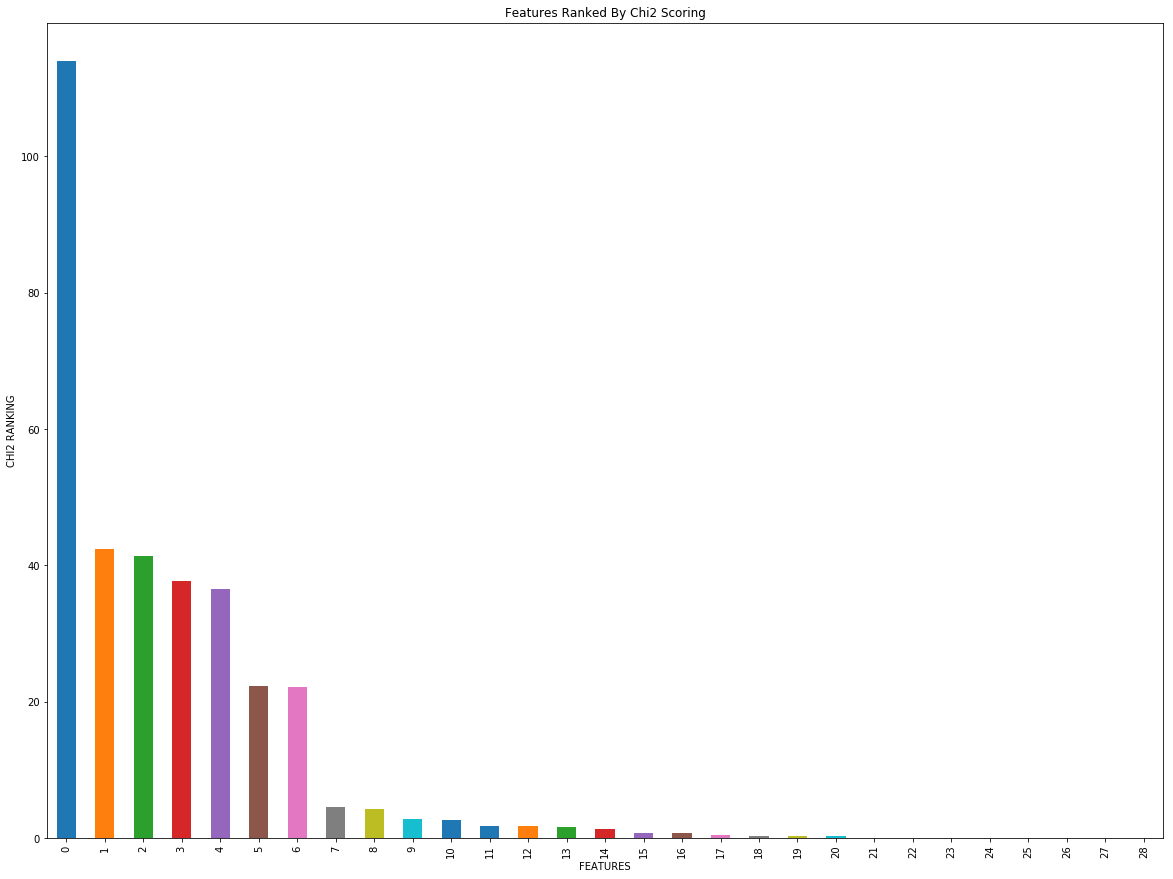



Table [REP_HIST_SYSMETRIC_SUMMARY]
Original number of features: 161
Reduced number of features: 30

Feature [PHYSICAL READ BYTES PER SEC] with score [48.897100387730134]
Feature [PHYSICAL READ TOTAL BYTES PER SEC] with score [47.895649486248026]
Feature [TOTAL PGA ALLOCATED] with score [44.09936028343496]
Feature [TOTAL PGA USED BY SQL WORKAREAS] with score [30.66054208732538]
Feature [CELL PHYSICAL IO INTERCONNECT BYTES] with score [30.421498610847657]
Feature [TEMP SPACE USED] with score [2.0562320538040963]
Feature [PHYSICAL WRITE TOTAL BYTES PER SEC] with score [1.0792315205248348]
Feature [REDO GENERATED PER SEC] with score [0.8737549406599137]
Feature [PHYSICAL WRITE BYTES PER SEC] with score [0.49318776084541305]
Feature [NETWORK TRAFFIC VOLUME PER SEC] with score [0.24784236935656842]
Feature [CONSISTENT READ GETS PER TXN] with score [0.08159314068458219]
Feature [LOGICAL READS PER TXN] with score [0.08157387347204664]
Feature [VM IN BYTES PER SEC] with score [0.0639081243458

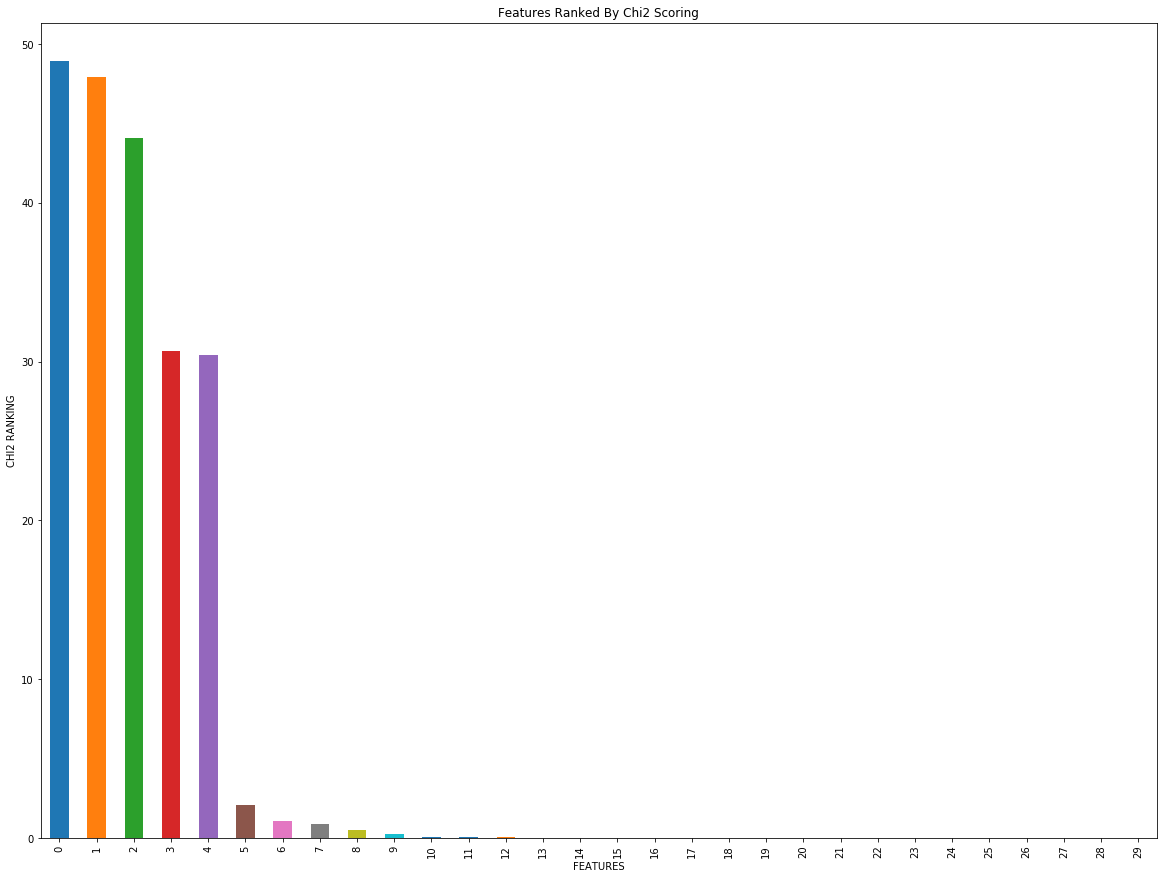



Table [REP_HIST_SYSSTAT]
Original number of features: 1178
Reduced number of features: 30

Feature [CELL PHYSICAL IO INTERCONNECT BYTES] with score [0.18641142614616507]
Feature [PHYSICAL READ TOTAL BYTES] with score [0.12018875718253332]
Feature [PHYSICAL READ BYTES] with score [0.11603940649846418]
Feature [SESSION UGA MEMORY MAX] with score [0.08070229107771794]
Feature [PHYSICAL WRITE TOTAL BYTES] with score [0.07001122576433698]
Feature [KTFB ALLOC SPACE (BLOCK)] with score [0.048235276379475035]
Feature [REDO SIZE] with score [0.0387235704472016]
Feature [PHYSICAL WRITE BYTES] with score [0.033654758094438075]
Feature [IMU REDO ALLOCATION SIZE] with score [0.013137732620640967]
Feature [UNDO CHANGE VECTOR SIZE] with score [0.011508185007253985]
Feature [SESSION UGA MEMORY] with score [0.010549622699546122]
Feature [BYTES RECEIVED VIA SQL*NET FROM CLIENT] with score [0.008878679227058255]
Feature [PROCESS LAST NON-IDLE TIME] with score [0.0071308130670515585]
Feature [SESSION CO

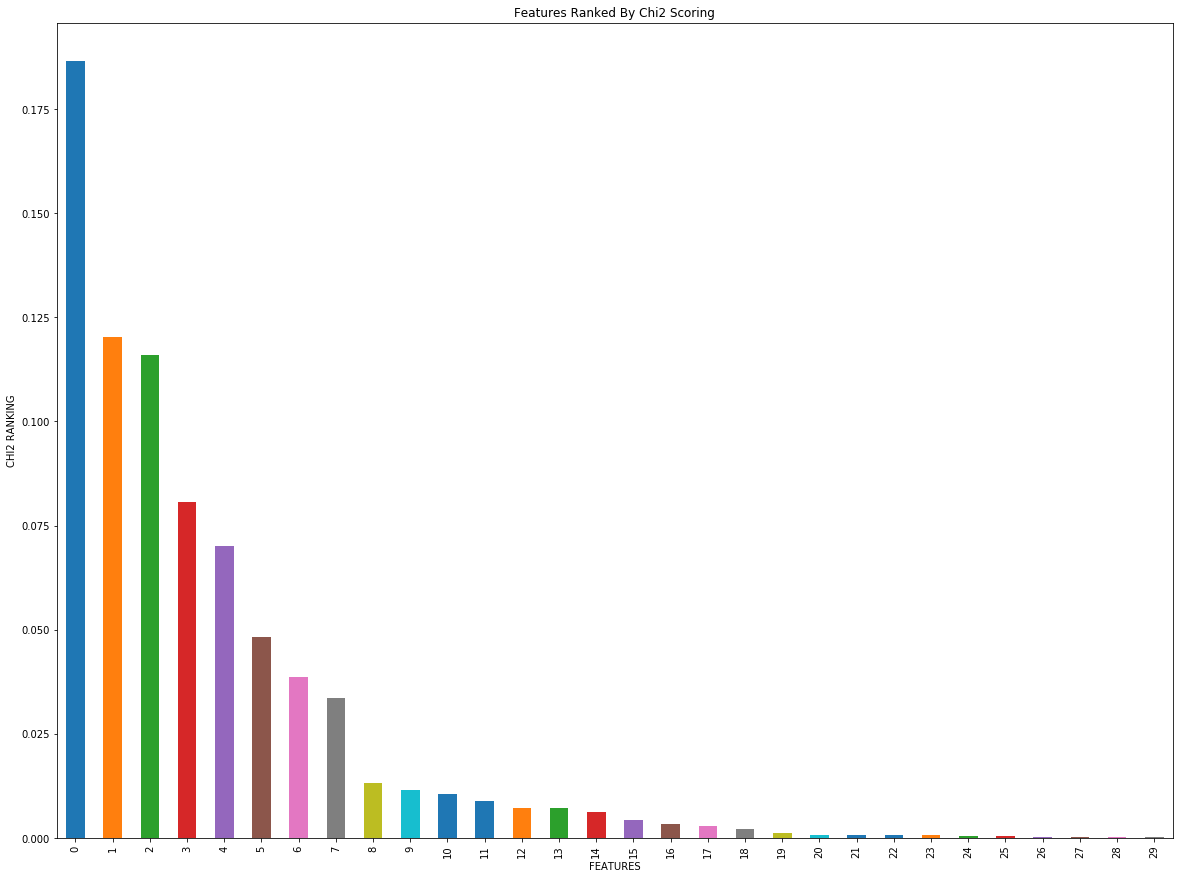

In [93]:
top_n_features=30
def chi2_test(top_n_features=30, X_df=None, y_df=None, table=None, headers=None):
    """
    Carries out a chi squared test on passed X,y dataframes, selecting top N features ranked by highest scoring
    """
    chi2_selector = SelectKBest(score_func=chi2, k=top_n_features)
    X_kbest = chi2_selector.fit_transform(X_df, y_df)
    print('\n\nTable [' + table.upper() + ']')
    print('Original number of features: ' + str(X_df.shape[1]))
    print('Reduced number of features: ' + str(X_kbest.shape[1]) + "\n")
    outcome = chi2_selector.get_support()
    #
    scoring_sheet = []
    for i in range(0,len(headers)-1):
        if outcome[i]:
            scoring_sheet.append([headers[i],chi2_selector.scores_[i]])
    #
    scoring_sheet = sorted(scoring_sheet, key=itemgetter(1), reverse=True)
    [print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scoring_sheet[:top_n_features]]
    #
    scoring_sheet = pd.Series((v[1] for v in scoring_sheet[:top_n_features]) )
    scoring_sheet[:top_n_features].plot.bar()
    plt.ylabel('CHI2 RANKING')
    plt.xlabel('FEATURES')
    plt.title('Features Ranked By Chi2 Scoring')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
chi2_test(top_n_features=top_n_features, X_df=rep_hist_snapshot_df_pruned_norm, y_df=y_label_snap_id, table='REP_HIST_SNAPSHOT', headers=retain_headers_rep_hist_snapshot)
chi2_test(top_n_features=top_n_features, X_df=rep_hist_sysmetric_summary_df_pruned_norm, y_df=y_label_snap_id, table='REP_HIST_SYSMETRIC_SUMMARY', headers=retain_headers_rep_hist_sysmetric_summary)
chi2_test(top_n_features=top_n_features, X_df=rep_hist_sysstat_df_pruned_norm, y_df=y_label_snap_id, table='REP_HIST_SYSSTAT', headers=retain_headers_rep_hist_sysstat)

### Random Forest Feature Importance

Calculating MI (Mutual Information) scoring between data matrix X (feature vectors) and target column y ('SNAP_ID') 

                              importance
feature                                 
IOWAIT_TOTAL                       0.293
PLSEXEC_TIME_TOTAL                 0.280
DISK_READS_TOTAL                   0.055
IOWAIT_DELTA                       0.048
CPU_TIME_DELTA                     0.037
ELAPSED_TIME_DELTA                 0.024
DISK_READS_DELTA                   0.024
IO_INTERCONNECT_BYTES_DELTA        0.020
SHARABLE_MEM                       0.019
PHYSICAL_READ_REQUESTS_TOTAL       0.017
PHYSICAL_READ_BYTES_DELTA          0.017
OPTIMIZER_COST                     0.014
PHYSICAL_WRITE_BYTES_DELTA         0.012
ROWS_PROCESSED_TOTAL               0.012
PHYSICAL_READ_BYTES_TOTAL          0.012
PLSEXEC_TIME_DELTA                 0.010
IO_INTERCONNECT_BYTES_TOTAL        0.009
CPU_TIME_TOTAL                     0.008
ELAPSED_TIME_TOTAL                 0.008
BUFFER_GETS_TOTAL                  0.008
PHYSICAL_READ_REQUESTS_DELTA       0.007
FETCHES_TOTAL                      0.007
CCWAIT_TOTAL    

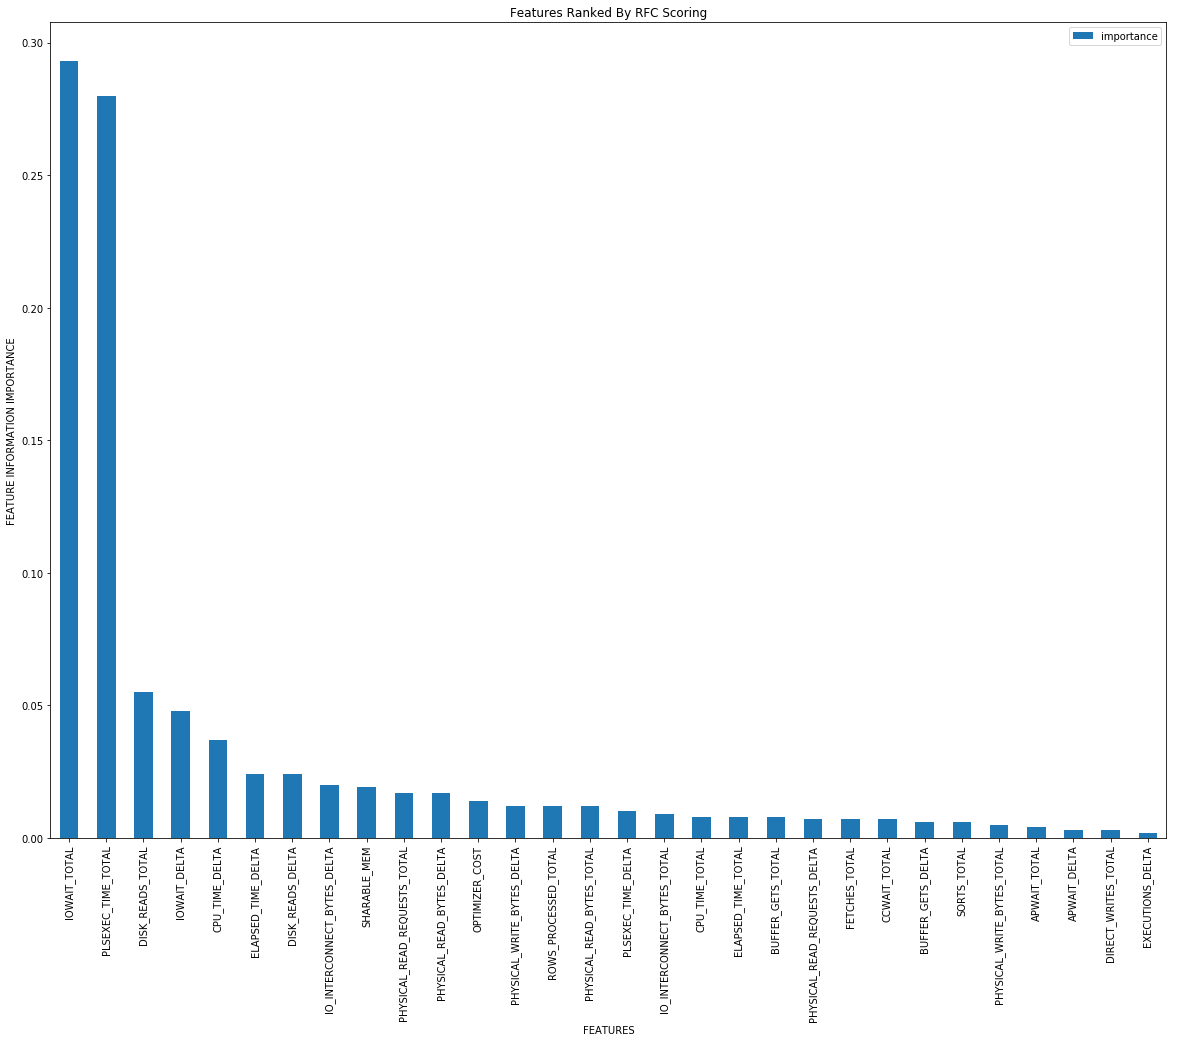

                                     importance
feature                                        
PHYSICAL READ BYTES PER SEC               0.098
PHYSICAL READ TOTAL BYTES PER SEC         0.089
TEMP SPACE USED                           0.071
PHYSICAL WRITE BYTES PER SEC              0.066
NETWORK TRAFFIC VOLUME PER SEC            0.057
REDO GENERATED PER TXN                    0.051
PHYSICAL WRITE TOTAL BYTES PER SEC        0.050
VM IN BYTES PER SEC                       0.043
VM OUT BYTES PER SEC                      0.042
REDO GENERATED PER SEC                    0.039
TXNS PER LOGON                            0.039
TOTAL INDEX SCANS PER SEC                 0.038
LOGICAL READS PER SEC                     0.037
CELL PHYSICAL IO INTERCONNECT BYTES       0.035
TOTAL PGA ALLOCATED                       0.032
CONSISTENT READ GETS PER SEC              0.022
TOTAL INDEX SCANS PER TXN                 0.018
ROWS PER SORT                             0.017
LOGICAL READS PER TXN                   

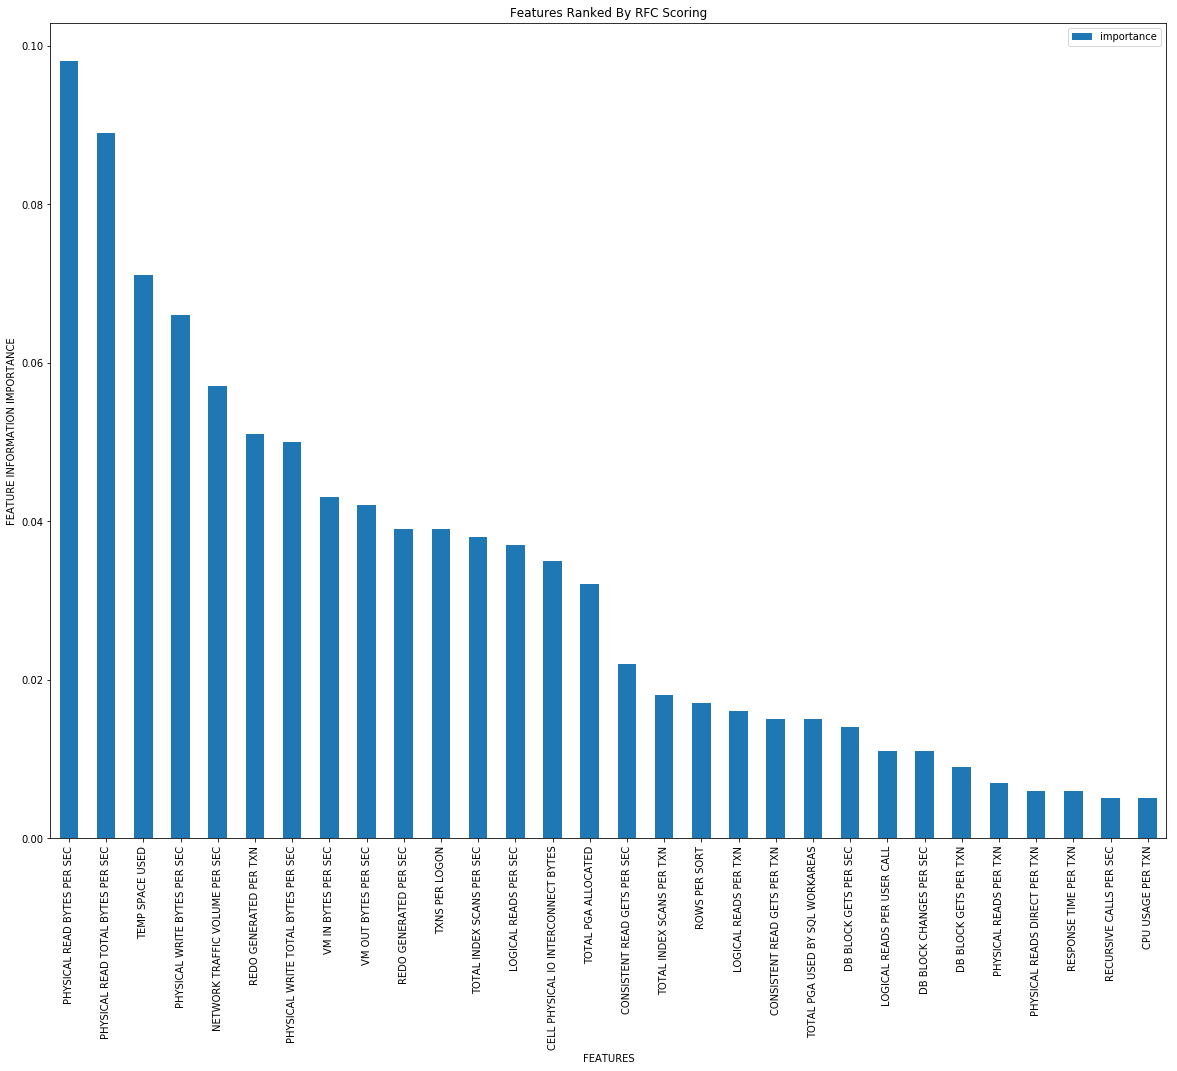

                                        importance
feature                                           
PROCESS LAST NON-IDLE TIME                   0.227
SESSION CONNECT TIME                         0.218
TABLE FETCH BY ROWID                         0.075
LOGICAL READ BYTES FROM CACHE                0.042
INDEX FETCH BY KEY                           0.037
CELL PHYSICAL IO INTERCONNECT BYTES          0.037
CONSISTENT GETS EXAMINATION                  0.035
SORTS (ROWS)                                 0.035
CONSISTENT GETS EXAMINATION (FASTPATH)       0.034
SESSION UGA MEMORY MAX                       0.031
PHYSICAL READ BYTES                          0.030
PHYSICAL READ TOTAL BYTES                    0.027
PHYSICAL WRITE BYTES                         0.021
TABLE SCAN ROWS GOTTEN                       0.020
PHYSICAL WRITE TOTAL BYTES                   0.020
TBS EXTENSION: BYTES EXTENDED                0.017
REDO SYNCH TIME (USEC)                       0.017
TABLE SCAN DISK NON-IMC ROWS GO

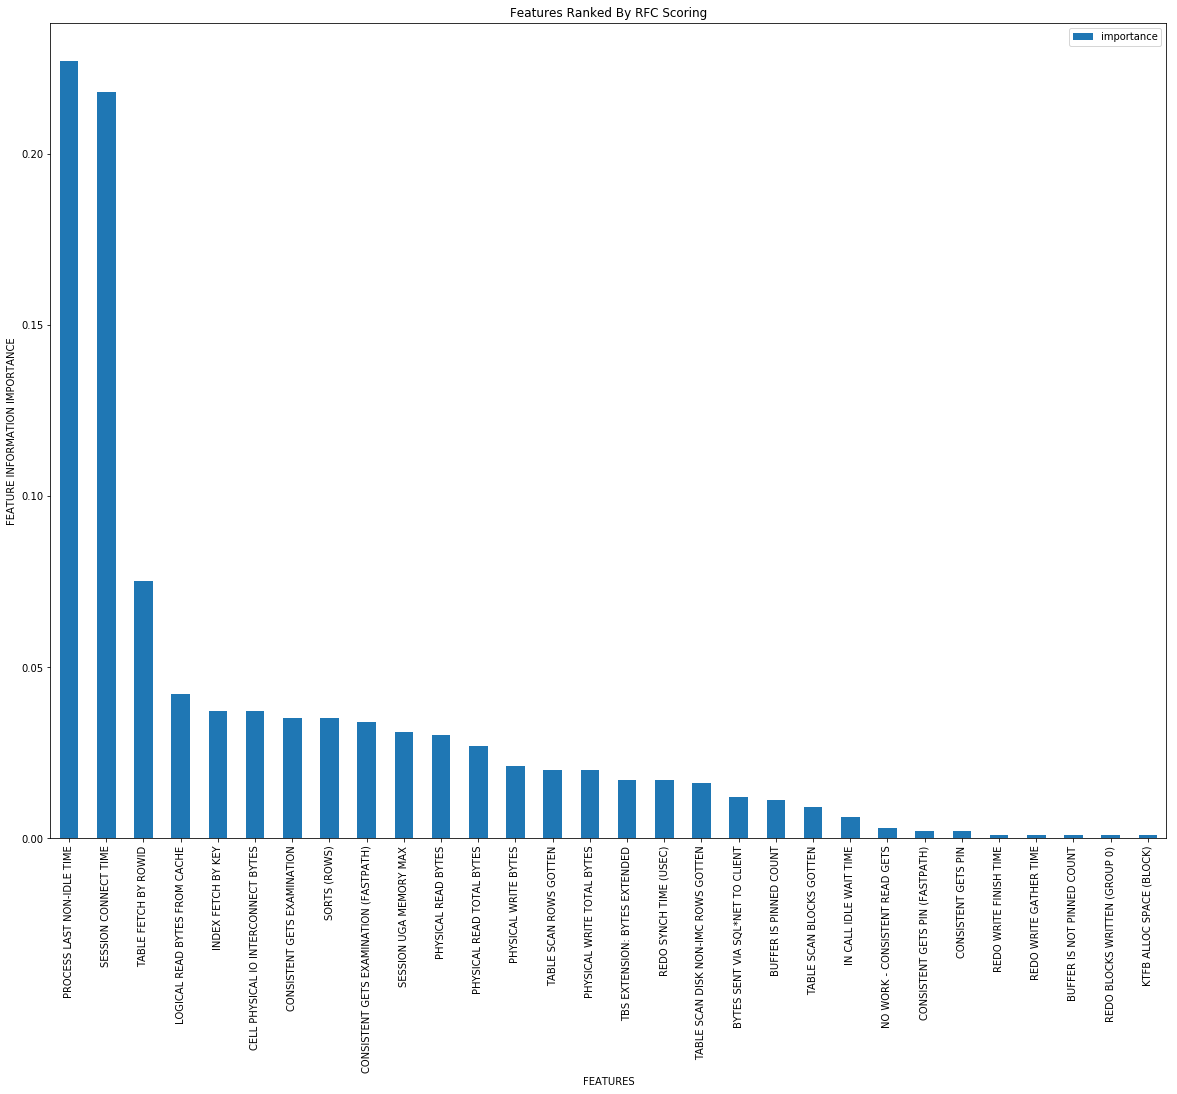

In [94]:
def rfr_ranking(X_df=None, y_df=None, headers=None, top_n_features=30):
    """
    Ranks features using a filter RFR method, and plots them in descending order (ranked by importance)
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    rfr = RandomForestRegressor(n_estimators=2000)
    rfr.fit(X_df, y_df)
    importances = pd.DataFrame({'feature':headers,
                                'importance':np.round(rfr.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    print(importances[:top_n_features])
    importances[:top_n_features].plot.bar()
    plt.ylabel('FEATURE INFORMATION IMPORTANCE')
    plt.xlabel('FEATURES')
    plt.title('Features Ranked By RFC Scoring')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_snapshot_df_pruned_norm, 
            y_df=y_label_snap_id, 
            headers=retain_headers_rep_hist_snapshot)
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_sysmetric_summary_df_pruned_norm, 
            y_df=y_label_snap_id, 
            headers=retain_headers_rep_hist_sysmetric_summary)
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_sysstat_df_pruned_norm, 
            y_df=y_label_snap_id, 
            headers=retain_headers_rep_hist_sysstat)

### Wrapper Methods

Use a number of machine learning models to evaluate features individually and rank by highest. The following machine learning models will be opted for:

* Random Forest Classifier
* Gradient Boosting

In a 'Brute-Fore' approach, these machine learning heuristics will strip away 1 feature at a time in a method referred to as 'Recursive Feature Elimination', and compare accuracy with every variable elimination. This allows the respective classifier to establish an optimum feature configuration with the highest accuracy score.

https://www.fabienplisson.com/choosing-right-features/

### Random Forest Wrapper (Feature Combination)

In [95]:
def rfr_wrapper(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None):
    """
    Random Forest Regressor - Takes data matrix and target vector, and evaluates best combination of features 
    using an RFR model.
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    val_op, optimum_features = 0, 0
    val_op = 0
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    model = RandomForestRegressor(n_estimators=feature_count)
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))
    # 
    # fit model using each importance as a threshold
    #print(type(model.feature_importances_))
    thresholds = np.sort(model.feature_importances_)[:feature_count]
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = RandomForestRegressor(n_estimators=feature_count)
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
        if(r2s > val_op):
            val_op = r2s
            optimum_features = select_train_x.shape[1]
    print("\n\n------------------------------------------\n\n")
    return val_op, optimum_features
#
rfr_rep_hist_snapshot_score, rfr_rep_hist_snapshot_count = rfr_wrapper(X_df=rep_hist_snapshot_df_pruned_norm,
                                                                        y_df=y_label_snap_id,
                                                                        test_split=test_split,
                                                                        table_name='REP_HIST_SNAPSHOT')
rfr_hist_sysmetric_summary_score, rfr_hist_sysmetric_summary_count = rfr_wrapper(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
                                                                                 y_df=y_label_snap_id,
                                                                                 test_split=test_split,
                                                                                 table_name='REP_HIST_SYSMETRIC_SUMMARY')
rfr_hist_sysstat_score, rfr_hist_sysstat_count = rfr_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                               y_df=y_label_snap_id,
                                                               test_split=test_split,
                                                               table_name='REP_HIST_SYSSTAT')

Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.6751663963245556


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6719857232180075


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6961058276093299


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6615380955833046


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6645788779745183


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6581512677383692


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6580481903691755


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.674709910832412


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6680614205194193


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6784795974772098


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6704542880185584


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6667655907352701


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.679289491092303


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=60, R2 Score: 0.6874988672816572


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.2138487803057137e-07, n=47, R2 Score: 0.6876093073200791


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00015496885591131376, n=46, R2 Score: 0.672567374087029


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00023205688850495046, n=45, R2 Score: 0.6771690423546043


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0008818271481038837, n=44, R2 Score: 0.683508300560016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0009161371961740577, n=43, R2 Score: 0.6814173024992297


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0009881881500894505, n=42, R2 Score: 0.6722286913025355


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0010549818676193188, n=41, R2 Score: 0.6758216738858582


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0012216671310819134, n=40, R2 Score: 0.6722507793102198


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0014683838606705758, n=39, R2 Score: 0.6990214446236657


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0014748185817733774, n=38, R2 Score: 0.6965770384399297


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0018476630257375911, n=37, R2 Score: 0.667428230965801


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0021300290213093374, n=36, R2 Score: 0.6766462928394077


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.002188425961749063, n=35, R2 Score: 0.6691879089113217


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.002352524168303896, n=34, R2 Score: 0.7089831360893126


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.002722713617010543, n=33, R2 Score: 0.6558762029468801


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0027246594325198905, n=32, R2 Score: 0.6943314243253529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00291996088748485, n=31, R2 Score: 0.6735539717635972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0030185319553186567, n=30, R2 Score: 0.6726189127716258


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0037824238069848228, n=29, R2 Score: 0.6623185385214854


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0038728400771358635, n=28, R2 Score: 0.6823302734835166


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00448813377251862, n=27, R2 Score: 0.6703585733185928
Thresh=0.004980838892006964, n=26, R2 Score: 0.6690774688729


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.005293502639718978, n=25, R2 Score: 0.6758658499012269


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.008493190105823743, n=24, R2 Score: 0.6731048489406818
Thresh=0.009209301894867683, n=23, R2 Score: 0.6890965665041593
Thresh=0.00970984749396894, n=22, R2 Score: 0.6724127580332384


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.009850049955441425, n=21, R2 Score: 0.6824112628450261


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.009947287679562877, n=20, R2 Score: 0.6827720336372038


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.010122790037419928, n=19, R2 Score: 0.6791054243615999
Thresh=0.014438019457148382, n=18, R2 Score: 0.7047716892908277


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.015699666809399083, n=17, R2 Score: 0.7079449997281475
Thresh=0.01575811757318312, n=16, R2 Score: 0.6864239175743516


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.015871510842953906, n=15, R2 Score: 0.677397285100676
Thresh=0.016176268001846413, n=14, R2 Score: 0.671043301556808


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.017161723698974937, n=13, R2 Score: 0.7067890606593327
Thresh=0.017302494034323893, n=12, R2 Score: 0.6854373198977834


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.020661611190998394, n=11, R2 Score: 0.6723464940101853
Thresh=0.020804175994490925, n=10, R2 Score: 0.6786047628540877


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.02155801319367444, n=9, R2 Score: 0.6555227948239303
Thresh=0.02171844164646868, n=8, R2 Score: 0.671647040433514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.03347664715860395, n=7, R2 Score: 0.6632020588288599
Thresh=0.0392444228245926, n=6, R2 Score: 0.6692615356036029


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.04434772128206409, n=5, R2 Score: 0.6845464369211809
Thresh=0.08201491709727743, n=4, R2 Score: 0.6888756864273158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.08564181415196692, n=3, R2 Score: 0.7619207278394984
Thresh=0.1907977704384454, n=2, R2 Score: 0.6657863557279301


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.21927849911389705, n=1, R2 Score: 0.21621440998966956


------------------------------------------


Table [REP_HIST_SYSMETRIC_SUMMARY] RFR R2 Score: -0.09841517613596773


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07225956401904621


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.0804041357973897


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.055040596200138125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.12290915785836432


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.063968631014242


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07954318740644428


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.036237483341890364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05242331309166404


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05776119311552552


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.034868575400287316


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.060085753771078165


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.048729844494508345


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06306463520374916


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.1086776809560368


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.041627020269208614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05636645672219398


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.10673193759250021


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.13202660131847632


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05844134234437237


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.02666373723457749


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.0333360872644044


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07935377876043637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.08335718877833243


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.021015915789975637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07240592524550693


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.10686107985114202


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.027076992462231386


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06186791694033511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.08009419437664933


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07600468951965866


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.04756756416673191


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05716713872577328


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.0724575821489637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06960784297493428


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.08925468525630853


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07127808285336834


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: 0.0027893072196648605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.059388385574412395


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.08360686381170668


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07591859468056428


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.012879953495541496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05077890166495824


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.0627374748151901


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.026147168200010285


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.09238853739934982


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.013878653629038284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.10297820260797819


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.04868679707496093


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.09454951786062282


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.025725303488447038


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.0761940981656668


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.030288329960457716


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07463578157805562


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.057907554341986245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07503181783789037


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06861775232534706


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05535914710478784


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06264277049218592


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.04931528940035124


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.09322365733856675


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07041713446242293


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06631902012152291


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07017606891295824


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.074076165123941


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06014602015844428


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.03894947077336841


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07743386384862805


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07731333107389582


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07210459330867591


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.06928068258637499


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.07113172162690762


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.05417964780919271


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.03471360468991702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.09411043418124065


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=161, R2 Score: -0.08603473827417263


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=6.9020974007305e-08, n=86, R2 Score: -0.05535053762087849


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.1579728631253964e-07, n=85, R2 Score: -0.054808140134582795


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.3690870739085737e-07, n=84, R2 Score: 0.00018924307900969328


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.4112265719645483e-06, n=83, R2 Score: -0.0424965781440636


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.031789954895408e-06, n=82, R2 Score: -0.0930428581764684


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.709891500966394e-06, n=81, R2 Score: -0.07793321391537633


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.4863499828378364e-06, n=80, R2 Score: -0.06924624465073737


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=6.690899354566522e-06, n=79, R2 Score: -0.08717979963413014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=9.405876873256164e-06, n=78, R2 Score: -0.08418369923364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.1419884659507352e-05, n=77, R2 Score: -0.02505376374350954


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.1733275895976381e-05, n=76, R2 Score: -0.04974576359582383


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.7538152287737437e-05, n=75, R2 Score: -0.10224639647567457


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.9043530275104995e-05, n=74, R2 Score: -0.056745274014210034


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.3276370941844263e-05, n=73, R2 Score: -0.04498471899389567


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.406774496174945e-05, n=72, R2 Score: -0.031054574028399173


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.472710545592242e-05, n=71, R2 Score: -0.04866957810714201


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.6625370416436504e-05, n=70, R2 Score: -0.01393031053249505


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.880804233402519e-05, n=69, R2 Score: -0.04500193796171459


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.9095270435173046e-05, n=68, R2 Score: -0.06129969100231114


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.686699259305959e-05, n=67, R2 Score: -0.06780846083785841


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.9932669758093104e-05, n=66, R2 Score: -0.07262977182715269


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.8683363608748004e-05, n=65, R2 Score: -0.06388253617514739


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=6.859475564727202e-05, n=64, R2 Score: -0.09045140351972258


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=8.921009475081433e-05, n=63, R2 Score: -0.043589982600564126


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0001535290022500799, n=62, R2 Score: -0.0821346420631901


------------------------------------------


Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.9976158465415117


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9977133398056134


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968890785727531


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971283802210029


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9965522836604016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9963750231802166


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970042978848734


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.997695613757595


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972701886051509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969688457888364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974119969892989


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.997482901181373


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973322297732157


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972170104610955


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9976690246855672


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973233667492064


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969599827648271


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968447634527069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969333936927994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973322297732157


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973499558212342


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969688457888364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9965522836604016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9966231878524756


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971461062690214


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973499558212342


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.996880215548744


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974917642053822


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969954348608642


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.99680931135667


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970220239328919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974208600133082


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9966763659965312


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.996951119740818


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974119969892989


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968979415967624


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970840651009567


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974208600133082


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972790516291602


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.996880215548744


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968713525247347


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969156676447809


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972258734851047


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968890785727531


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971017911489751


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971283802210029


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973056407011879


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.997553805373447


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973410927972249


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967029550685589


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968270374046884


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971017911489751


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972435995331231


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9975715314214654


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971904213890677


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967827222846422


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9975272163014192


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967384071645959


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973676818692526


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971372432450122


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971372432450122


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970308869569011


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969954348608642


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9965345576123832


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9965877357564387


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9974119969892989


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.996951119740818


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972701886051509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970308869569011


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967649962366236


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972524625571324


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9975094902534006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.997624709565521


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970752020769474


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972258734851047


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967738592606329


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968713525247347


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9970486130049196


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968270374046884


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971106541729844


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.996880215548744


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9975449423494377


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969688457888364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971549692930307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9967649962366236


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969245306687902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9966054618044572


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9975449423494377


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973233667492064


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9971283802210029


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9968447634527069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972170104610955


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9973765448932619


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972701886051509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969245306687902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9966763659965312


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9969245306687902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9972790516291602


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9966497769245034


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=1178, R2 Score: 0.9964370643482814
Thresh=0.0, n=1178, R2 Score: 0.9971638323170399


------------------------------------------




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


### Gradient Boosting Wrapper (Feature Combination)

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

In [96]:
def gradient_boosting_wrapper(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None):
    """
    Gradient Boosting Regressor - Takes data matrix and target vector, and evaluates best combination of features 
    using a GBR model.
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    val_op, optimum_features = 0, 0
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    model = GradientBoostingRegressor(n_estimators=feature_count)
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))
    # 
    # fit model using each importance as a threshold
    #print(type(model.feature_importances_))
    thresholds = np.sort(model.feature_importances_)[:feature_count]
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = GradientBoostingRegressor(n_estimators=feature_count)
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
        if(r2s > val_op):
            val_op = r2s
            optimum_features = select_train_x.shape[1]
    print("\n\n------------------------------------------\n\n")
    return val_op, optimum_features
#
gbw_rep_hist_snapshot_score, gbw_rep_hist_snapshot_count = gradient_boosting_wrapper(X_df=rep_hist_snapshot_df_pruned_norm,
                                                                                      y_df=y_label_snap_id,
                                                                                      test_split=test_split,
                                                                                      table_name='REP_HIST_SNAPSHOT')
gbw_hist_sysmetric_summary_score, gbw_hist_sysmetric_summary_count = gradient_boosting_wrapper(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
                                                                                              y_df=y_label_snap_id,
                                                                                              test_split=test_split,
                                                                                              table_name='REP_HIST_SYSMETRIC_SUMMARY')
gbw_hist_sysstat_score, gbw_hist_sysstat_count = gradient_boosting_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                                          y_df=y_label_snap_id,
                                                                          test_split=test_split,
                                                                          table_name='REP_HIST_SYSSTAT')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.6954766571145242
Thresh=0.0, n=60, R2 Score: 0.6872360708964416
Thresh=0.0, n=60, R2 Score: 0.693492641395725
Thresh=0.0, n=60, R2 Score: 0.6923668278250574
Thresh=0.0, n=60, R2 Score: 0.6828896922752579
Thresh=0.0, n=60, R2 Score: 0.6773990441232319
Thresh=0.0, n=60, R2 Score: 0.6930127864311781
Thresh=0.0, n=60, R2 Score: 0.6794753396429056
Thresh=0.0, n=60, R2 Score: 0.6937787087784355
Thresh=0.0, n=60, R2 Score: 0.6869407755336434
Thresh=0.0, n=60, R2 Score: 0.6875775061596767
Thresh=0.0, n=60, R2 Score: 0.6863225008677851
Thresh=0.0, n=60, R2 Score: 0.6875590501995019
Thresh=0.0, n=60, R2 Score: 0.6900782887633726
Thresh=0.0, n=60, R2 Score: 0.6802781739105128
Thresh=0.0, n=60, R2 Score: 0.6820038061868638
Thresh=5.369928783420141e-07, n=45, R2 Score: 0.6841170136268873
Thresh=5.783145923034019e-06, n=44, R2 Score: 0.6887125477104317
Thresh=3.1740489733062715e-05, n=43, R2 Score: 0.687540594239327
Thresh=0.0003109280674776213, n=42, R2 Sco

Thresh=0.0, n=161, R2 Score: -0.3962061411766846
Thresh=0.0, n=161, R2 Score: -0.3829970406940282
Thresh=0.0, n=161, R2 Score: -0.41026771395886064
Thresh=0.0, n=161, R2 Score: -0.3748943336886925
Thresh=0.0, n=161, R2 Score: -0.41416714170517843
Thresh=0.0, n=161, R2 Score: -0.41712125363420705
Thresh=0.0, n=161, R2 Score: -0.39943034333922434


------------------------------------------


Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.9988182196055173
Thresh=0.0, n=1178, R2 Score: 0.9987530179285803
Thresh=0.0, n=1178, R2 Score: 0.9988752710728371
Thresh=0.0, n=1178, R2 Score: 0.9990871765228824
Thresh=0.0, n=1178, R2 Score: 0.9987285672997289
Thresh=0.0, n=1178, R2 Score: 0.9988997217016885
Thresh=0.0, n=1178, R2 Score: 0.998801919186283
Thresh=0.0, n=1178, R2 Score: 0.9988997217016885
Thresh=0.0, n=1178, R2 Score: 0.9984759108015981
Thresh=0.0, n=1178, R2 Score: 0.9989730735882426
Thresh=0.0, n=1178, R2 Score: 0.9989160221209228
Thresh=0.0, n=1178, R2 Score: 0.9990056744267111
Thresh=0.0

### Recursive Feature Elimination

In [97]:
if rfr_rep_hist_snapshot_score > gbw_rep_hist_snapshot_score:
    rep_hist_snapshot_op = rfr_rep_hist_snapshot_count
    rep_hist_snapshot_model = 0
else:
    rep_hist_snapshot_op = gbw_rep_hist_snapshot_count
    rep_hist_snapshot_model = 1
#
if rfr_hist_sysmetric_summary_score > gbw_hist_sysmetric_summary_score:
    rep_hist_sysmetric_summary_op = rfr_hist_sysmetric_summary_count
    rep_hist_sysmetric_summary_model = 0
else:
    rep_hist_sysmetric_summary_op = gbw_hist_sysmetric_summary_count
    rep_hist_sysmetric_summary_model = 1
#
if rfr_hist_sysstat_score > gbw_hist_sysstat_score:
    rep_hist_sysstat_op = rfr_hist_sysstat_count
    rep_hist_sysstat_model = 0
else:
    rep_hist_sysstat_op = gbw_hist_sysstat_count
    rep_hist_sysstat_model = 1
#
def rfe_selector(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None, optimum_feature_count=0, model=None):
    """
    Recursive Feature Elimination Function
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    if model == 0:
        model = RandomForestRegressor(n_estimators=feature_count)
    elif model == 1:
        model = GradientBoostingRegressor(n_estimators=feature_count)
    #
    # create the RFE model and select 4 attributes
    rfe_model = RFE(model, optimum_feature_count, step=1)
    rfe_model = rfe_model.fit(X_train, y_train)
    # 
    # summarize the selection of the attributes
    #     print(rfe_model.support_)
    #     print(rfe_model.ranking_)
    # 
    # evaluate the model on testing set
    pred_y = rfe_model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s) + " with " + str(optimum_feature_count) + " features")
    print("\n\n------------------------------------------\n\n")
#
rfe_selector(X_df=rep_hist_snapshot_df_pruned_norm,
             y_df=y_label_snap_id,
             test_split=test_split,
             table_name='REP_HIST_SNAPSHOT',
             optimum_feature_count=rep_hist_snapshot_op,
             model = rep_hist_snapshot_model)
rfe_selector(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
             y_df=y_label_snap_id,
             test_split=test_split,
             table_name='REP_HIST_SYSMETRIC_SUMMARY',
             optimum_feature_count=rep_hist_sysmetric_summary_op,
             model = rep_hist_sysmetric_summary_model)
rfe_selector(X_df=rep_hist_sysstat_df_pruned_norm,
             y_df=y_label_snap_id,
             test_split=test_split,
             table_name='REP_HIST_SYSSTAT',
             optimum_feature_count=rep_hist_sysstat_op,
             model = rep_hist_sysstat_model)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.6816219815847964 with 3 features


------------------------------------------


Table [REP_HIST_SYSMETRIC_SUMMARY] RFR R2 Score: -0.21888071185809665 with 161 features


------------------------------------------


Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.9984970364800329 with 1178 features


------------------------------------------




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
